# Weather Forecasting time series
## Demo
**Prepared by György JABLONSZKY**

### I. Intro

This task is about preparing a weather forcast for Rio weather station for August, September and October 2019. I have a time series of a single variable, presumabely representing temperature values. Being on the southern hemisphere (I suppose in Rio de Janeiro) temperature is higher in 'winter' months i.e. December, January, February and lower in 'summer' months i.e. June, July, August. This makes time series a bit unusal for a guy like me, living in the northern hemisphere, so let's get understand how weather goes there.

In [35]:
# Import packages, apply settings and read source data
import pandas as pd
import numpy as np
from numpy import log
import plotly
import plotly.express as px
import plotly.graph_objects as go
import itertools
from matplotlib import pyplot as plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pylab import rcParams
from IPython.core.display import HTML, display
HTML("<style>.container { width: 100%; }</style>")
plotly.offline.init_notebook_mode(True)
import warnings

rcParams['figure.figsize'] = 25, 9
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

warnings.filterwarnings('ignore')

data = pd.read_csv('rio.csv', sep='\t', decimal='.')

As a first step I'm going to check data dimensions and have a look at data.
I have 29 observations along 13 variables at first sight, however, variables seem to be representing years and months formulating a time series for one variable.

In [8]:
# Get data dimensions, data types and first 9 observations with header
print(data.shape)
print(data.dtypes)
print(data.head(10))

(30, 13)
YEAR      int64
JAN     float64
FEB     float64
MAR     float64
APR     float64
MAY     float64
JUN     float64
JUL     float64
AUG     float64
SEP     float64
OCT     float64
NOV     float64
DEC     float64
dtype: object
   YEAR    JAN    FEB   MAR   APR   MAY   JUN    JUL    AUG    SEP    OCT  \
0  1990  28.63  27.47 27.50 27.05 22.19 21.50  20.25  19.95  21.17  24.21   
1  1991  25.44  26.43 25.52 24.72 21.69 21.42  19.64  20.91  20.80  23.59   
2  1992  27.37 999.90 26.75 24.63 23.55 23.31  20.77  20.94  21.74  23.67   
3  1993  27.48  27.25 26.81 25.68 22.85 20.98 999.90 999.90 999.90 999.90   
4  1994 999.90 999.90 26.56 24.97 23.95 21.16  21.59  20.85  22.72  24.56   
5  1995  28.64  27.59 26.75 24.97 23.17 21.84  23.06  23.90  23.05  23.21   
6  1996  28.48  28.17 26.76 25.09 22.01 21.16  19.65  20.59  21.44  23.50   
7  1997  26.52  28.03 25.35 24.57 22.43 21.53  22.00  21.76  23.28  24.25   
8  1998  28.57  28.32 27.72 26.03 22.89 20.59  21.30  23.21  23.48  23.23   

As the size of dataset is limited let's now just see it entirely.

What I have is a **time series for a single variable** indeed probably representing average monthly temperature for one weather station. 
Time frame covers a 29 years period between 1990 and 2019 having 12 data points for each year with some missing values marked with '999'.

To go further the following data manipulation steps should be taken:

<li>Set data to proper format for time series analysis</li>
<li>Manage missing values (with inputation)</li>

### II. Data understanding and data preparation

In [9]:
# Show the entire dataset
data

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1990,28.63,27.47,27.50,27.05,22.19,21.50,20.25,19.95,21.17,24.21,26.19,26.08
1,1991,25.44,26.43,25.52,24.72,21.69,21.42,19.64,20.91,20.80,23.59,24.49,27.26
2,1992,27.37,999.90,26.75,24.63,23.55,23.31,20.77,20.94,21.74,23.67,23.83,25.38
3,1993,27.48,27.25,26.81,25.68,22.85,20.98,999.90,999.90,999.90,999.90,999.90,999.90
4,1994,999.90,999.90,26.56,24.97,23.95,21.16,21.59,20.85,22.72,24.56,25.63,27.32
5,1995,28.64,27.59,26.75,24.97,23.17,21.84,23.06,23.90,23.05,23.21,25.13,25.93
6,1996,28.48,28.17,26.76,25.09,22.01,21.16,19.65,20.59,21.44,23.50,23.96,26.51
7,1997,26.52,28.03,25.35,24.57,22.43,21.53,22.00,21.76,23.28,24.25,26.27,27.77
8,1998,28.57,28.32,27.72,26.03,22.89,20.59,21.30,23.21,23.48,23.23,23.54,26.86
9,1999,27.83,27.96,27.00,24.69,22.21,21.25,21.56,20.94,22.77,21.62,23.04,25.70


I'm going to set a proper format for data e.g. having a year-month pair for each observation and apply date format.

I suppose values are representing temeprature in °C, therefore I'm going to refer them as temperature.

In [17]:
# Set dummy missing values to nan
data = data.replace(999.90, np.nan)

# Reshape data to a dataframe with observations ordered to one columns
data = data.set_index('YEAR')
rows = []
for year in data.index:
    for month in data.columns:
        rows.append([year, month, data.at[year, month]])
weather = pd.DataFrame(rows, columns=['year', 'month', 'temperature'])
 
# Extract dates, set date as index
weather['date'] = pd.to_datetime(weather['year'].astype(str) + weather['month'].astype(str), format='%Y%b')
weather = weather.set_index('date')
weather = weather['temperature']

As a result I have the same data in a format that is more suitable for time series analysis:

In [18]:
print(weather.head(10))
print(weather.tail(10))

date
1990-01-01   28.63
1990-02-01   27.47
1990-03-01   27.50
1990-04-01   27.05
1990-05-01   22.19
1990-06-01   21.50
1990-07-01   20.25
1990-08-01   19.95
1990-09-01   21.17
1990-10-01   24.21
Name: temperature, dtype: float64
date
2019-03-01   27.50
2019-04-01   26.55
2019-05-01   24.85
2019-06-01   23.10
2019-07-01   21.75
2019-08-01   22.30
2019-09-01   23.05
2019-10-01   25.25
2019-11-01     nan
2019-12-01     nan
Name: temperature, dtype: float64


Let's have same basic statistics about the original dataset and have a look at the values graphically.
*Please note that these statistics are calculated on the value set before missing value inputation.*

In [19]:
#Get some basic descriptive statistics _before_ missing value inputation
weather.describe()

count   326.00
mean     24.48
std       2.44
min      19.64
25%      22.44
50%      24.48
75%      26.52
max      30.25
Name: temperature, dtype: float64

In [20]:
fig = px.line(weather.reset_index(), x='date', y='temperature')
fig.show()

As one can see in the plot above we have to deal with missing data so I continue with finding a proper inputation method. We have 34 missing values in the entire dataset (almost 10% missing), however, for some years we have longer periods without having any observations. 

In [21]:
print("{}{}{}{}{}".format("We have ", weather.isna().sum(), " missing values out of ", weather.value_counts(dropna=False).sum(), " observations."))

We have 34 missing values out of 360 observations.


For cases when we miss one or two data points linear interpolitaion might be fair enough, however, for longer periods I'm going to try some different methods as well. Higher order polynomials will not be used in order to avoid getting overestmated high and low values.

In [22]:
# Apply different interpolation methods
interpolation_methods = ['linear', 'slinear', 'cubic', 'quadratic', 'time']
weather_interpolations = weather.to_frame()

for method in interpolation_methods:
    weather_interpolations[method] = weather_interpolations.temperature.interpolate(method=method)

weather_interpolations['spline_3'] = weather_interpolations.temperature.interpolate('spline', order=3)

# Visualize interpolations
weather_interpolations_melt = weather_interpolations.reset_index().melt(id_vars='date', value_vars=['temperature',
                                                                                                    'linear',
                                                                                                    'slinear',
                                                                                                    'cubic',
                                                                                                    'quadratic',
                                                                                                    'time',
                                                                                                    'spline_3'])
px.line(weather_interpolations_melt, x='date' , y='value' , color='variable')

Above interpolation methods work well for shorter time gaps, however, having a longer period without any value in a year (like in 2003 and 2007) they are inadequate to generate accurate inputations.
Therefore I'm going to calculate the avg. of before/after 1 and 2 years values and for longer period I will use these avg. values. For shorter periods (where there is no acg. calculated) I will apply results of cubic interpolations. For the last two months of the dataset I apply a simple time interpolation (i.e. use the same values as the last observation). This is a simplification, however, does not have any nagative impact on forecasting values for August, Seprember and October 2019.

In [23]:
# Calculate av. of before/after 1 and 2 years
weather_interpolations['shift'] =  (weather_interpolations.temperature.shift(12) + weather_interpolations.temperature.shift(24) + weather_interpolations.temperature.shift(-12) + + weather_interpolations.temperature.shift(-24))/4

# Calculate interpolations based on avg. values for before/sfter 1/2 years for longer periods and cubic interpolation method for shorter periods
weather_interpolations['temperature_interpolated'] = weather_interpolations['temperature'].fillna(weather_interpolations['shift'].fillna(weather_interpolations['cubic']).fillna(weather_interpolations['time']))
# Visualize interpolations and calculated shift
weather_interpolations_melt = weather_interpolations.reset_index().melt(id_vars='date', value_vars=['temperature',
                                                                                                    'linear',
                                                                                                    'slinear',
                                                                                                    'cubic',
                                                                                                    'quadratic',
                                                                                                    'time',
                                                                                                    'spline_3',
                                                                                                    'shift',
                                                                                                    'temperature_interpolated'])

px.line(weather_interpolations_melt, x='date' , y='value' , color='variable')

Now I'm going to set final weather time series, have a look at data and have some descriptive statistics. If it was a real business project I would explain results in details but in this demo I just print the results.

In [24]:
weather_data = weather_interpolations['temperature_interpolated']
weather_data.describe()

count   360.00
mean     24.49
std       2.41
min      19.64
25%      22.48
50%      24.52
75%      26.54
max      30.25
Name: temperature_interpolated, dtype: float64

### III. Modeling with parameter tuning

I'm starting with seasonal decomposition in order to get trend and seasonality. I will apply more methods and play a bit with frequency parameters (applying 4, 12 and 52 corresponding quarterly, monthly and weekly periodicity).

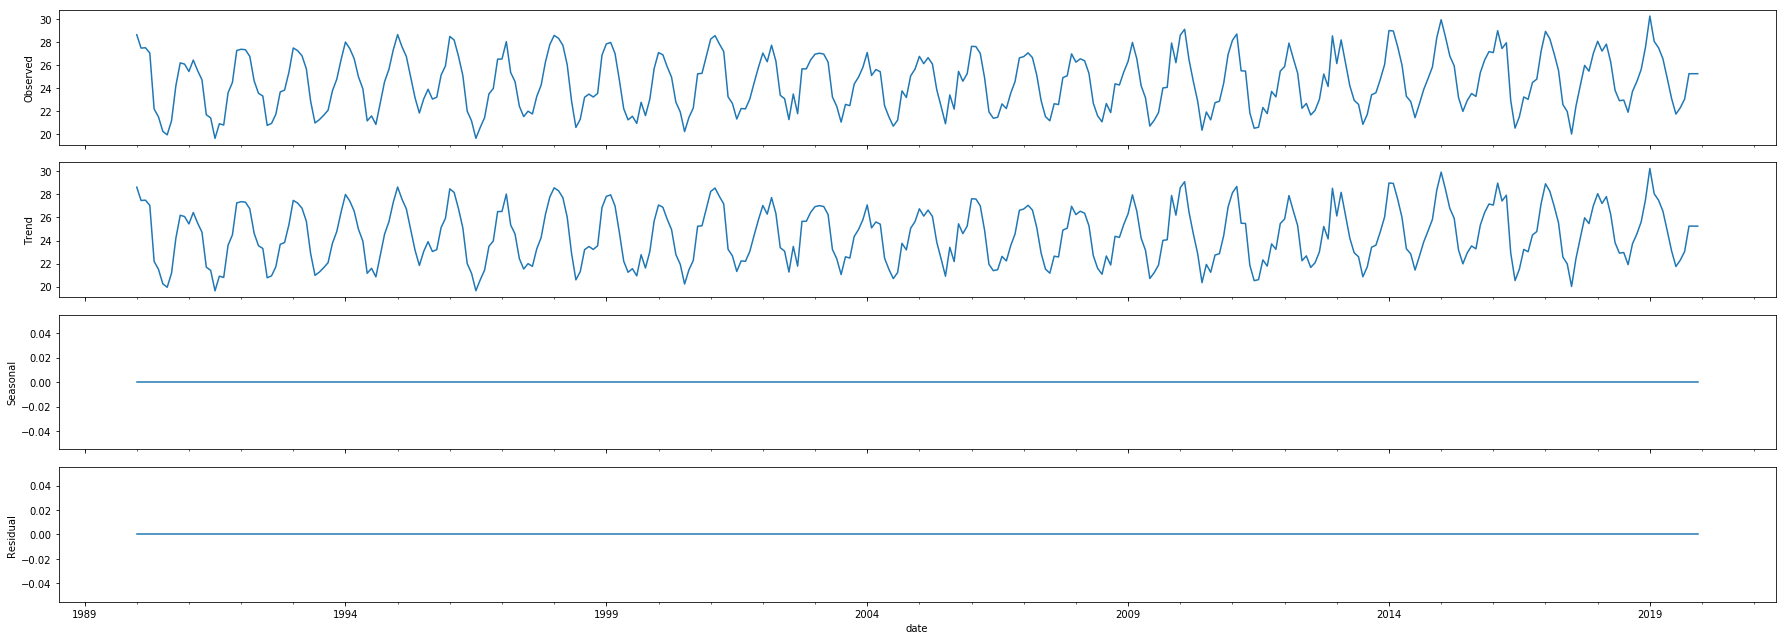

In [25]:
# Additive decomposition with frequency parameter set to 1 - will not be able to separate trend and seasonality
result = seasonal_decompose(weather_data, model='additive', freq=1)
result.plot()
plot.show()

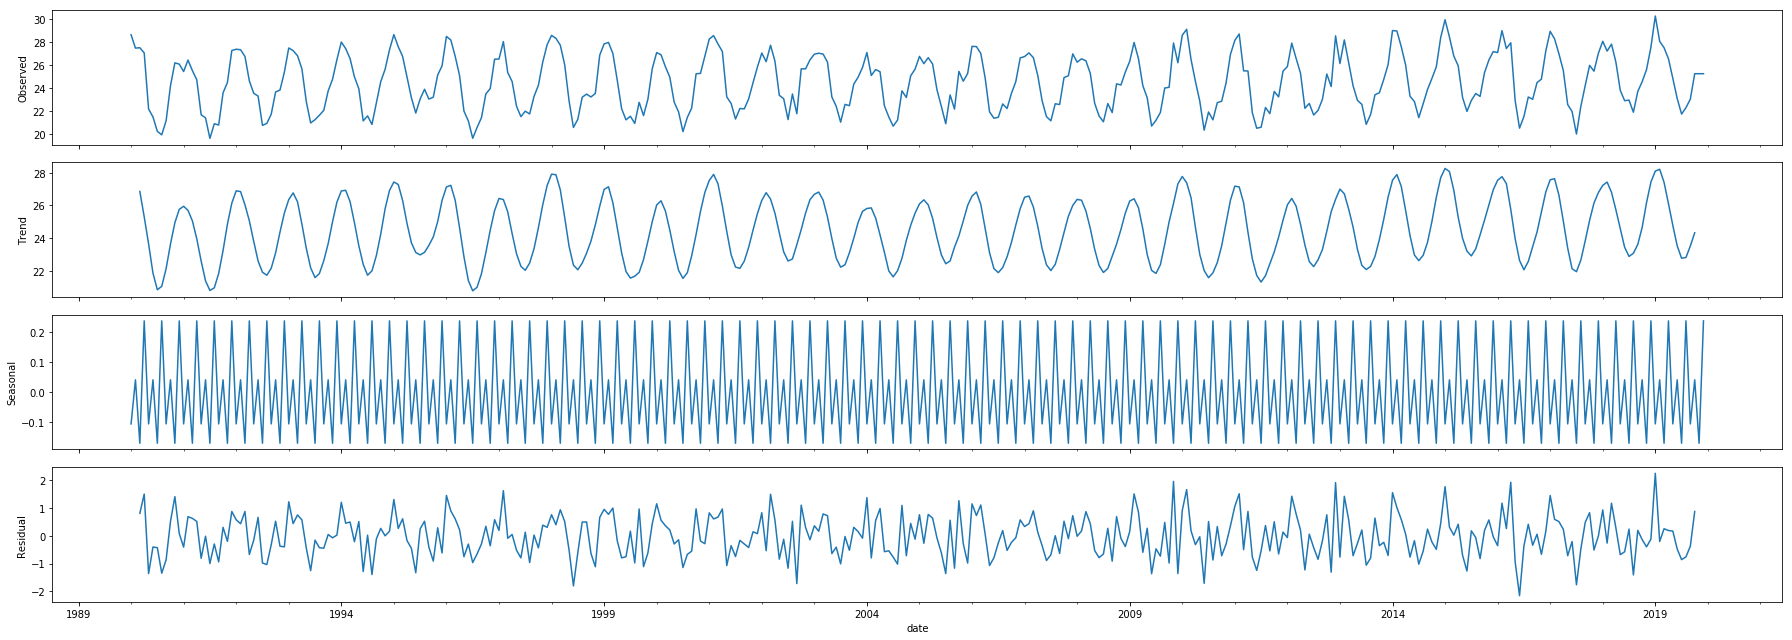

In [26]:
# Additive decomposition with frequency parameter set to 4 - still hard to observe trend
result = seasonal_decompose(weather_data, model='additive', freq=4)
result.plot()
plot.show()

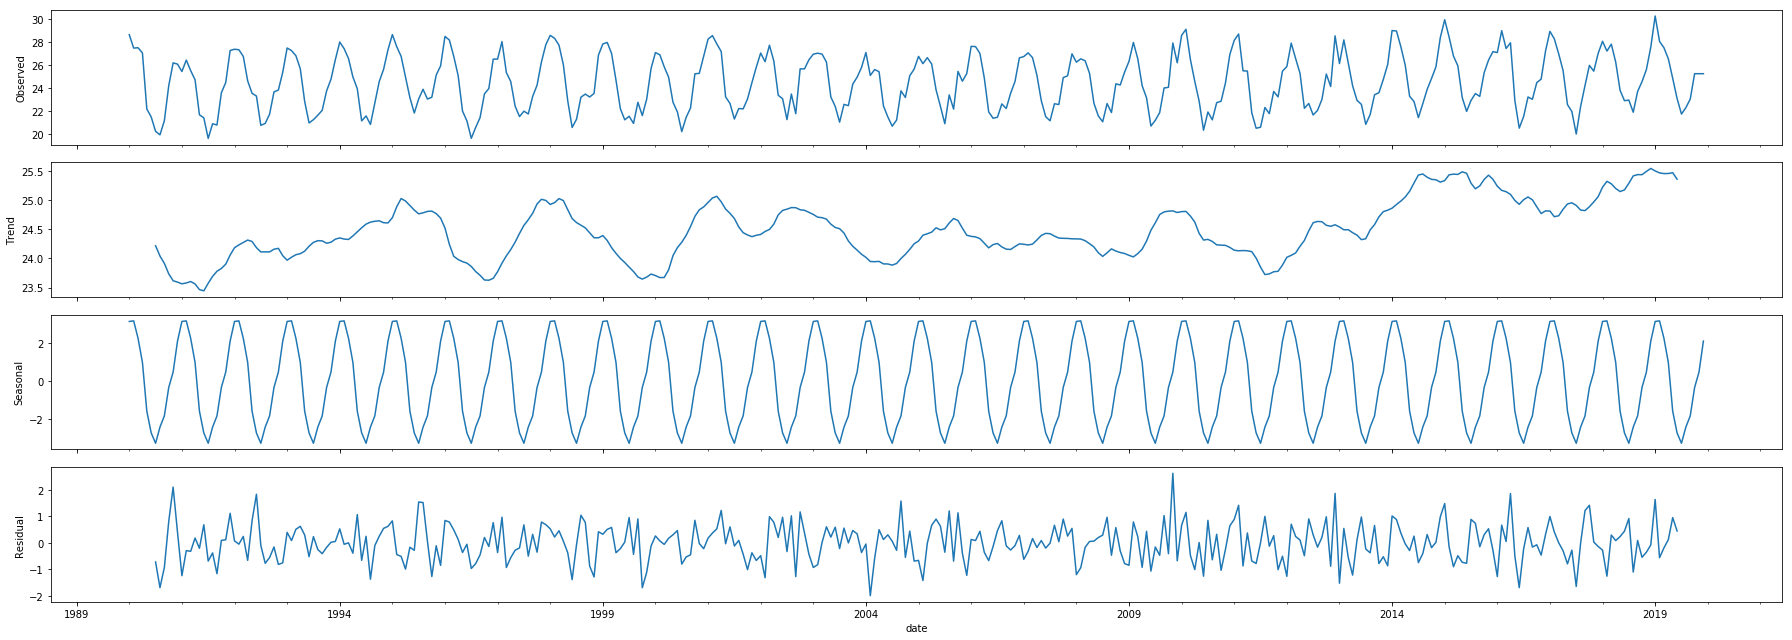

In [27]:
# Additive decomposition with frequency parameter set to 12 - now trend can be seen clearly. This parameter can be used as a reference.
result = seasonal_decompose(weather_data, model='additive', freq=12)
result.plot()
plot.show()

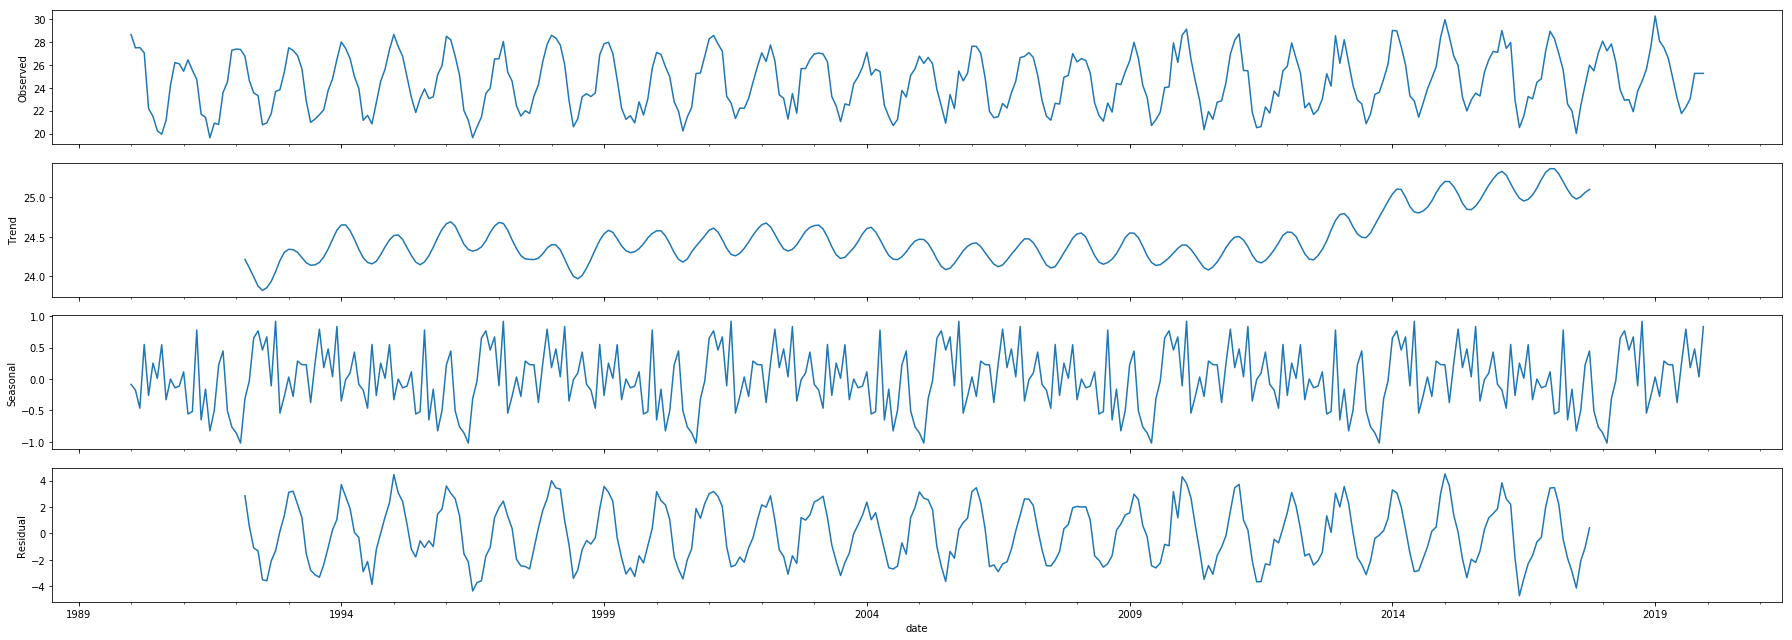

In [28]:
# Additive decomposition with frequency parameter set to 52 - we're getting too much in fragmentation
result = seasonal_decompose(weather_data, model='additive', freq=52)
result.plot()
plot.show()

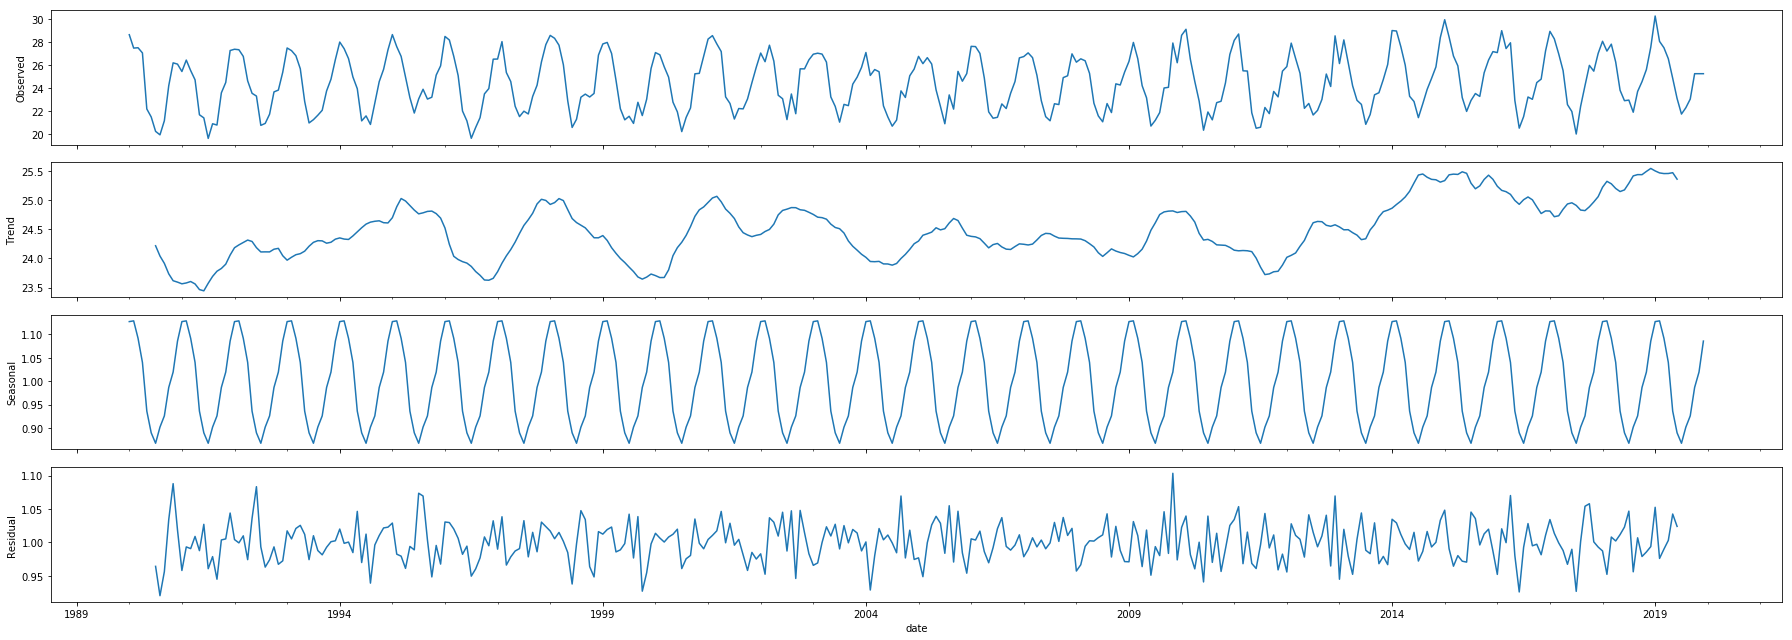

In [29]:
# Multiplicative decomposition with frequency parameter set to 12 
result = seasonal_decompose(weather_data, model='multiplicative', freq=12)
result.plot()
plot.show()

Having above results  efore moving forward to modeling I'm going to check stationarity with Augmented Dickey-Fuller test.

In [30]:
# First let's see the distribution of temperature levels
fig = px.histogram(weather_data, x="temperature_interpolated")
fig.show()

Our null hypothesis is the weather data have time dependeny i.e. it is not stationary. Let's now check it with ADF (for both temperature values and log temperature values).

In [31]:
adf = adfuller(weather_data.values)
print('Augmented Dickey-Fuller stats: %f' % adf[0])
print('p-value: %f' % adf[1])
print('critical values:')
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

Augmented Dickey-Fuller stats: -4.229342
p-value: 0.000587
critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


In [32]:
adf = adfuller(log(weather_data.values))
print('Augmented Dickey-Fuller stats: %f' % adf[0])
print('p-value: %f' % adf[1])
print('critical values:')
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

Augmented Dickey-Fuller stats: -4.223021
p-value: 0.000602
critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


Based on the results of the unit root tests we can reject our null hyothesis i.e. weather dataset is likely to be stationary (test stat value is less than the value az 1%).

We can now move forward forecasting. For this purpose I'm going to apply Autoregressive Integrated Moving Average Model (aka ARIMA). In ARIMA we can polay with the p, q and d terms corresponding to number of auto-regressive terms, number of moving-avergae terms and number of differencies. To get proper parameter values I use autocorrelation and partial autocorrelation functions and also iterate over possible combinations in order to get the lowest AIC indicating a proper parameter combination for the model.

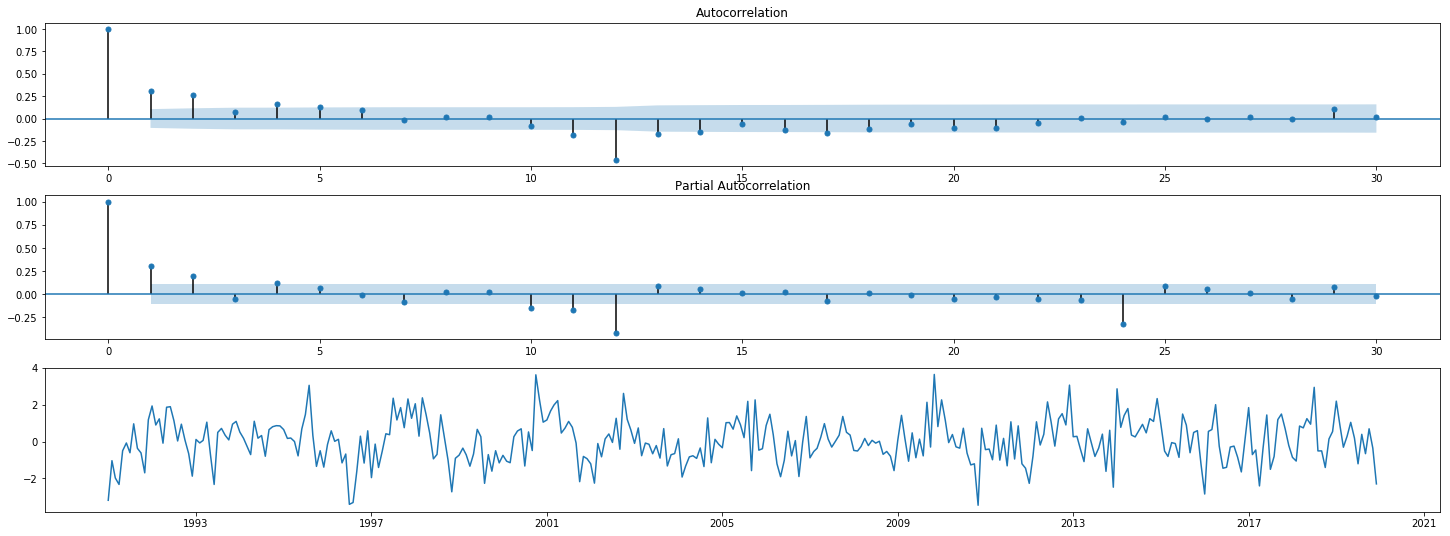

In [33]:
# Plot ACF, PACF
fig, ax = plot.subplots(3)
x = (weather_data - weather_data.shift(12)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=30)
ax[1] = plot_pacf(x, ax=ax[1], lags=30)
ax[2].plot(x)

In [36]:
#Searching for proper parameters I'll check possible combinations limiting the number of orders between 0 and 2.
p=d=q=range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model_param = SARIMAX(weather_data, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = model_param.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3320.237742192492
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2788.279313772668
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1104.5155428984312
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:911.0190814141906
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1115.884763016251
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:937.1109082337666
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:981.9710378882663
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:912.6466425740384
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2861.739086223215
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2394.3182049341676
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1080.2509701428085
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:890.2579694315831
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1093.9588678470275
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:915.2117441444548
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:968.311835364266
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:893.7408146949618
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1352.4575838125347
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1212.9755524009645
ARIMA

Based on resulsts I'm going to select the best available parameter set. For this purpose I check all the AIC vcalues and search for the lowest one (measuring the relative adequacy of the pamramere sets). Therefore will choose ARIMA(1, 0, 1)x(1, 1, 1, 12)12 for modeling.

In [37]:
# Fit the model
model_weather = SARIMAX(weather_data, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12), enforce_invertibility=False, enforce_stationarity=False)
model_weather_fit = model_weather.fit()

Let's see the model fit metrics now: get a summary table and resudal diagnostics.

In [38]:
#  Get model summary table
results = model_weather_fit
print((results.summary().tables[1]))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8469      0.055     15.386      0.000       0.739       0.955
ma.L1         -0.6108      0.086     -7.066      0.000      -0.780      -0.441
ar.S.L12       0.0402      0.056      0.722      0.470      -0.069       0.149
ma.S.L12      -1.0000    106.794     -0.009      0.993    -210.311     208.311
sigma2         0.6548     69.945      0.009      0.993    -136.435     137.745


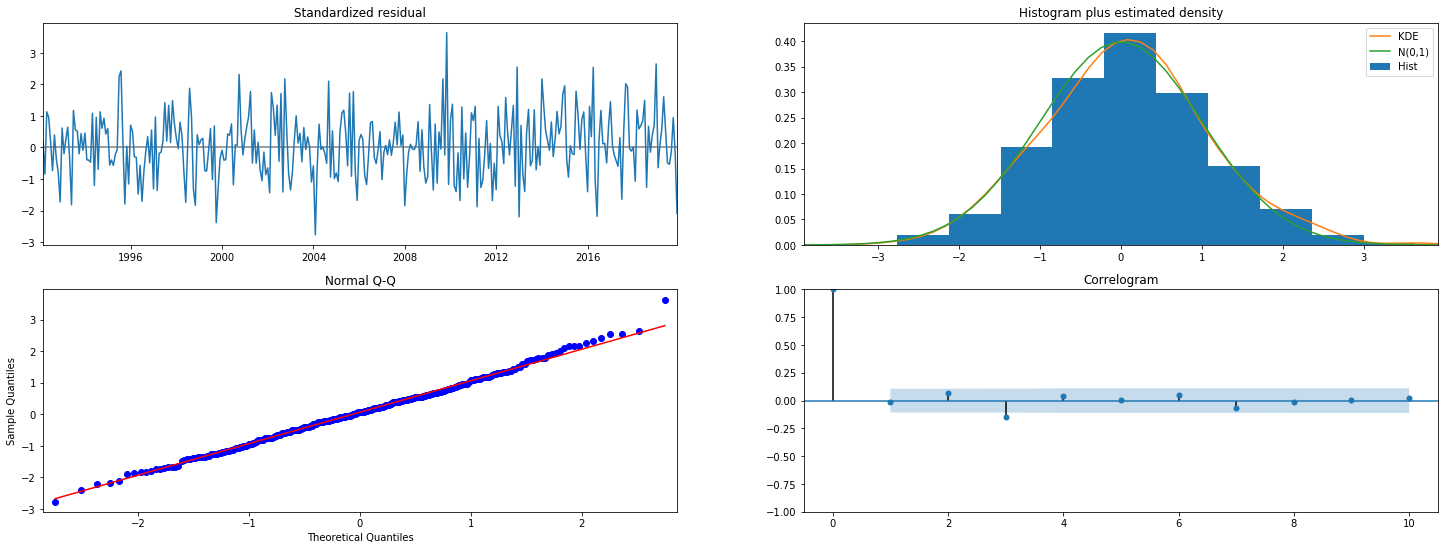

In [39]:
# Plot residuals and check their normality (i.e. normal distrubution)
results.plot_diagnostics()
plot.show()

As the goal of this task is not to find the best available parameters I accept the resulst and going to make predictions with the above fit model.

In [40]:
# Make predictions for August, September and Octovbe 2019
weather_prediction = results.get_prediction(start=pd.to_datetime('2019-08-01'), full_results=True, dynamic=False)
prediction_confidence_interval = weather_prediction.conf_int()

In [41]:
# Get predictions for the desired months
prediction = []
prediction = weather_prediction #results.get_prediction(start=pd.to_datetime('2019-08-01'), full_results=True, dynamic=False)
prediction = prediction.predicted_mean
print(prediction)

2019-08-01   22.74
2019-09-01   23.16
2019-10-01   24.47
2019-11-01   25.38
2019-12-01   26.98
Freq: MS, dtype: float64


My model predicted:
<li>22.74 °C for August 2019 (measured value was 22.30 °C)</li>
<li>23.16 °C for September 2019 (measured value was 23.05 °C)</li>
<li>24.47 °C for October 2019 (measured value was 25.25 °C)</li>

In [42]:
# Get metrics: Mean Squared Error and Root Mean Squared Error
weather_forecasted = weather_prediction.predicted_mean
weather_truth = weather_data['2019-08-01':]
mse = ((weather_forecasted - weather_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.76
The Root Mean Squared Error of our forecasts is 0.87


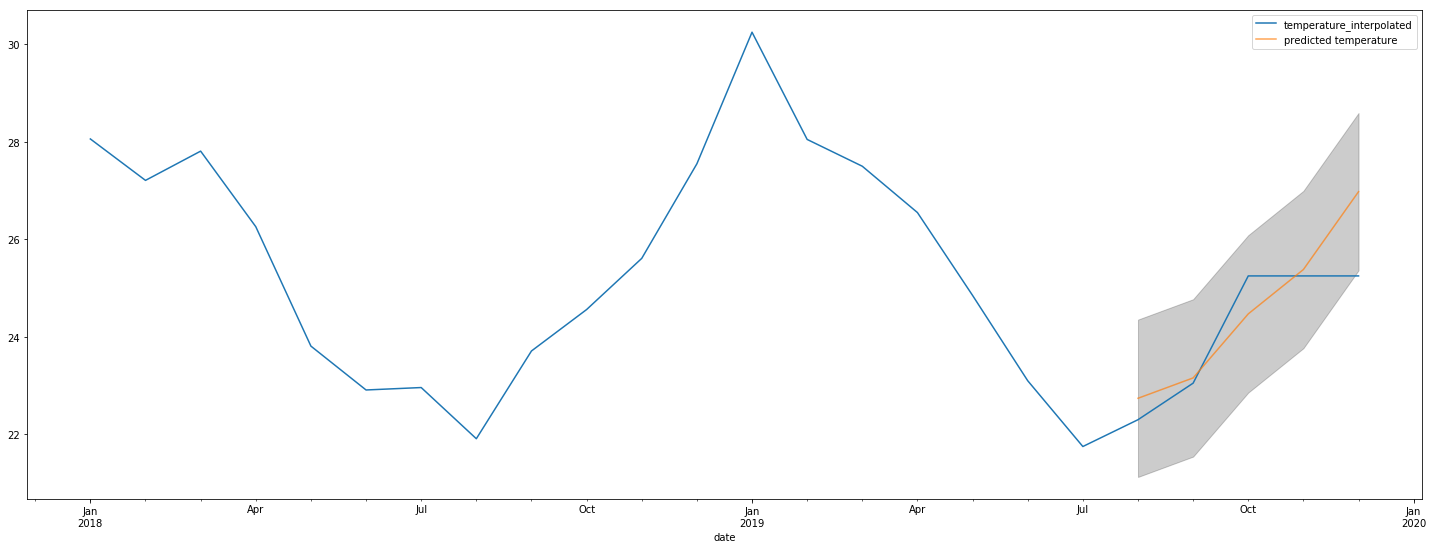

In [43]:
#Plot results
ax = weather_data['2018':].plot()
weather_prediction.predicted_mean.plot(ax=ax, label='predicted temperature', alpha=.7)
ax.fill_between(prediction_confidence_interval.index,
                prediction_confidence_interval.iloc[:, 0],
                prediction_confidence_interval.iloc[:, 1], color='k', alpha=.2)
plot.legend()
plot.show()

**Predictions are close to actual values that can be seen within the confidence interval.**

+1: Just for fun: let's see how the model permofms on a longer run

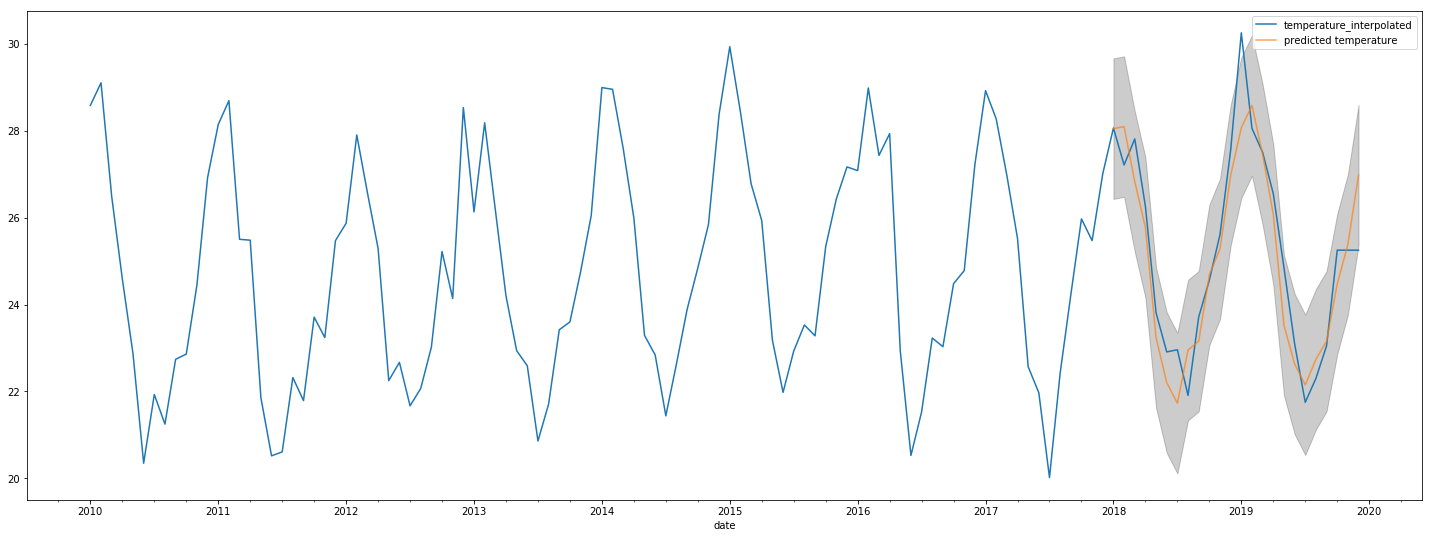

In [44]:
weather_prediction_long = results.get_prediction(start=pd.to_datetime('2018-01-01'), full_results=True, dynamic=False)
prediction_confidence_interval_long = weather_prediction_long.conf_int()
#Plot results
ax = weather_data['2010':].plot()
weather_prediction_long.predicted_mean.plot(ax=ax, label='predicted temperature', alpha=.7)
ax.fill_between(prediction_confidence_interval_long.index,
                prediction_confidence_interval_long.iloc[:, 0],
                prediction_confidence_interval_long.iloc[:, 1], color='k', alpha=.2)
plot.legend()
plot.show()